In [1]:
import os
import logging
import warnings

import numpy  as np
import glob
import matplotlib.pyplot as plt

from krcal.core.kr_types                      import masks_container
from krcal.map_builder.map_builder_functions  import calculate_map
from krcal.core.kr_types                      import FitType
from krcal.core.fit_functions                 import expo_seed
from krcal.core.selection_functions           import selection_in_band
from krcal.map_builder.map_builder_functions  import e0_xy_correction

from krcal.map_builder.map_builder_functions  import check_failed_fits
from krcal.map_builder.map_builder_functions  import regularize_map
from krcal.map_builder.map_builder_functions  import remove_peripheral
from krcal.map_builder.map_builder_functions  import add_krevol
from invisible_cities.reco.corrections        import read_maps
from krcal.core.io_functions                  import write_complete_maps

from krcal.NB_utils.xy_maps_functions         import draw_xy_maps
from krcal.core    .map_functions             import relative_errors
from krcal.core    .map_functions             import add_mapinfo

from krcal.NB_utils.plt_functions             import plot_s1histos, plot_s2histos
from krcal.NB_utils.plt_functions             import s1d_from_dst, s2d_from_dst
from krcal.NB_utils.plt_functions             import plot_selection_in_band

from invisible_cities.core.configure          import configure
from invisible_cities.io.dst_io               import load_dst, load_dsts
from invisible_cities.core.core_functions     import in_range
from invisible_cities.core.core_functions     import shift_to_bin_centers
from invisible_cities.core.fit_functions      import profileX

In [2]:
run_number = 8087 # 0 or negative for MC

In [3]:
input_folder       = '/Users/taylorcontreras/Development/Research/nz_studies/data/trigger1/8087/'
input_dst_file     = '*.h5'
input_dsts         = glob.glob(input_folder + input_dst_file)

In [4]:
dst = load_dsts(input_dsts, 'DST', 'Events')
dst = dst.sort_values(by=['time'])
dst = dst[in_range(dst.R, 0, 200)]

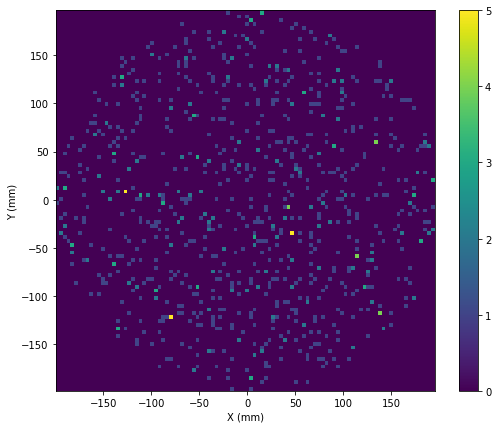

In [5]:
plt.figure(figsize=(8.5, 7));
plt.hist2d(dst.X, dst.Y, 100);
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');
plt.colorbar();

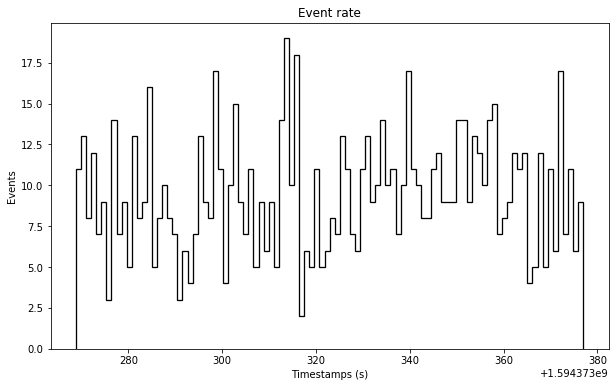

In [6]:
if run_number>0:
    plt.figure(figsize=(10, 6));
    plt.hist(dst.time, 100, histtype='step', color='k', linewidth=1.3)
    plt.xlabel('Timestamps (s)');
    plt.ylabel('Events');
    plt.title('Event rate');

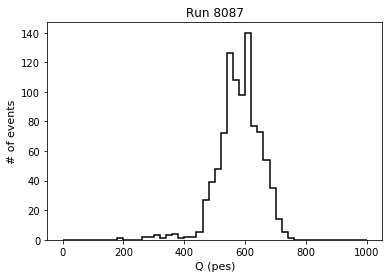

In [7]:
bins = 50
plt.xlabel(r'Q (pes)',fontsize = 11) #xlabel
plt.ylabel('# of events', fontsize = 11)
plt.hist(dst.S2q,
        range=(0,1000),
        bins=bins,
        histtype='step',
        edgecolor='black',
        linewidth=1.5,
        )
plt.title('Run '+str(run_number))
plt.show()

In [8]:
mask_s1 = dst.nS1==1
mask_s2 = np.zeros_like(mask_s1)
mask_s2[mask_s1] = dst[mask_s1].nS2 == 1
nevts_after      = dst[mask_s2].event.nunique()
nevts_before     = dst[mask_s1].event.nunique()
eff              = nevts_after / nevts_before
print('S2 selection efficiency: ', eff*100, '%')

S2 selection efficiency:  98.59943977591037 %


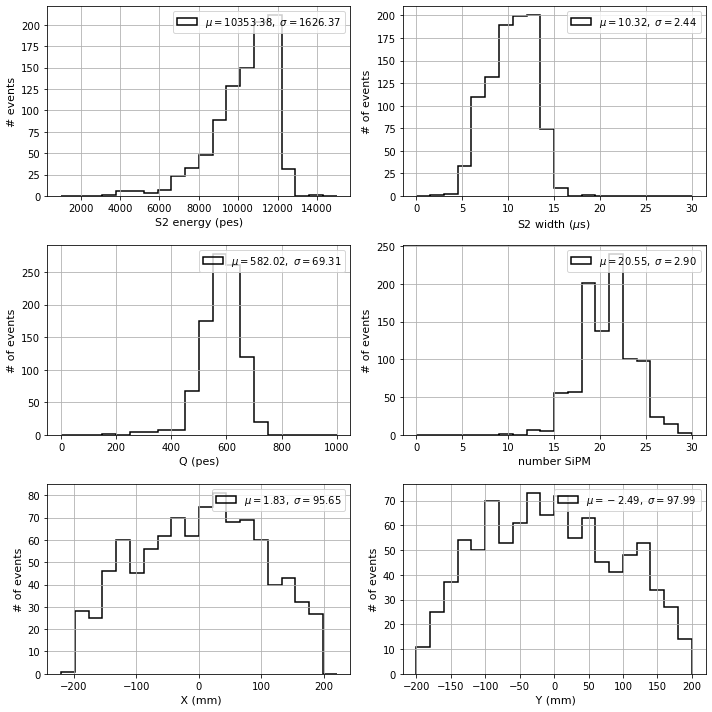

In [9]:
s2d = s2d_from_dst(dst[mask_s1])
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

## Band selection

In [10]:
z_range_plot = (0, 600)
e_range_plot = (0, 18000)
q_range_plot = (0, 1000)

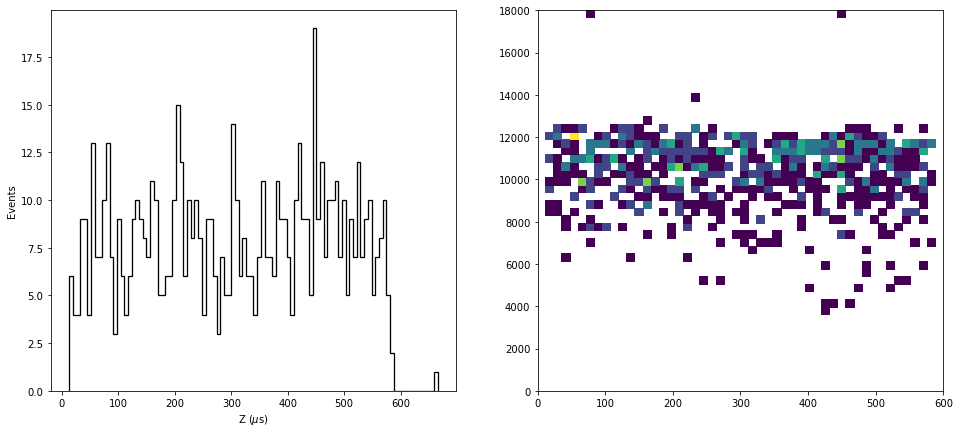

In [11]:
plt.figure(figsize=(16, 7));
plt.subplot(121);
plt.hist(dst[mask_s2].Z, 100, histtype='step', linewidth=1.3, color='k');
plt.xlabel(r'Z ($\mu$s)');
plt.ylabel('Events');
plt.subplot(122);
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e, 50, [z_range_plot, e_range_plot], cmin=1);

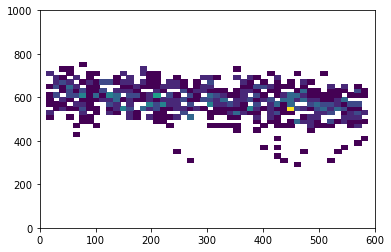

In [12]:
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2q, 50, [z_range_plot, q_range_plot], cmin=1);

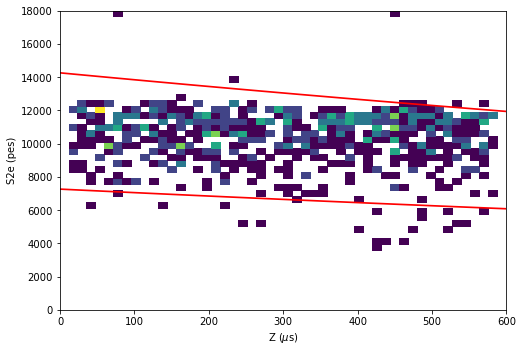

In [31]:
x, y, _ = profileX(dst[mask_s2].Z, dst[mask_s2].S2e, yrange=e_range_plot)
e0_seed, lt_seed = expo_seed(x, y)
lower_e0, upper_e0 = e0_seed-3000, e0_seed+4000    # play with these values to make the band broader or narrower

plt.figure(figsize=(8, 5.5))
xx = np.linspace(z_range_plot[0], z_range_plot[1], 100)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e, 50, [z_range_plot, e_range_plot], cmin=1);
plt.plot(xx, (lower_e0)*np.exp(xx/lt_seed), color='red', linewidth=1.7)
plt.plot(xx, (upper_e0)*np.exp(xx/lt_seed), color='red', linewidth=1.7)
plt.xlabel(r'Z ($\mu$s)');
plt.ylabel('S2e (pes)');

sel_krband = np.zeros_like(mask_s2)
Zs = dst[mask_s2].Z
sel_krband[mask_s2] = in_range(dst[mask_s2].S2e, (lower_e0)*np.exp(Zs/lt_seed), (upper_e0)*np.exp(Zs/lt_seed))

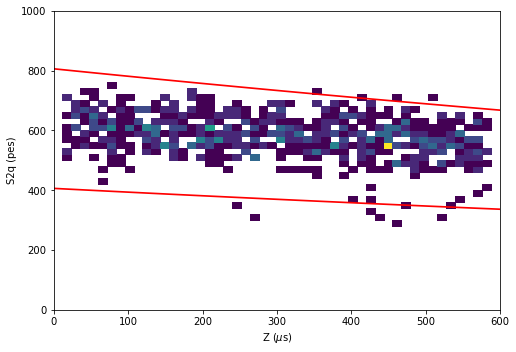

In [14]:
x, y, _ = profileX(dst[mask_s2].Z, dst[mask_s2].S2q, yrange=q_range_plot)
e0_seed, lt_seed = expo_seed(x, y)
lower_e0, upper_e0 = e0_seed-200, e0_seed+200    # play with these values to make the band broader or narrower

plt.figure(figsize=(8, 5.5))
xx = np.linspace(z_range_plot[0], z_range_plot[1], 100)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2q, 50, [z_range_plot, q_range_plot], cmin=1);
plt.plot(xx, (lower_e0)*np.exp(xx/lt_seed), color='red', linewidth=1.7)
plt.plot(xx, (upper_e0)*np.exp(xx/lt_seed), color='red', linewidth=1.7)
plt.xlabel(r'Z ($\mu$s)');
plt.ylabel('S2q (pes)');

sel_krband = np.zeros_like(mask_s2)
Zs = dst[mask_s2].Z
sel_krband[mask_s2] = in_range(dst[mask_s2].S2q, (lower_e0)*np.exp(Zs/lt_seed), (upper_e0)*np.exp(Zs/lt_seed))

In [15]:
print(lt_seed)

-3186.5993870499547


In [16]:
sel_dst = dst[sel_krband]

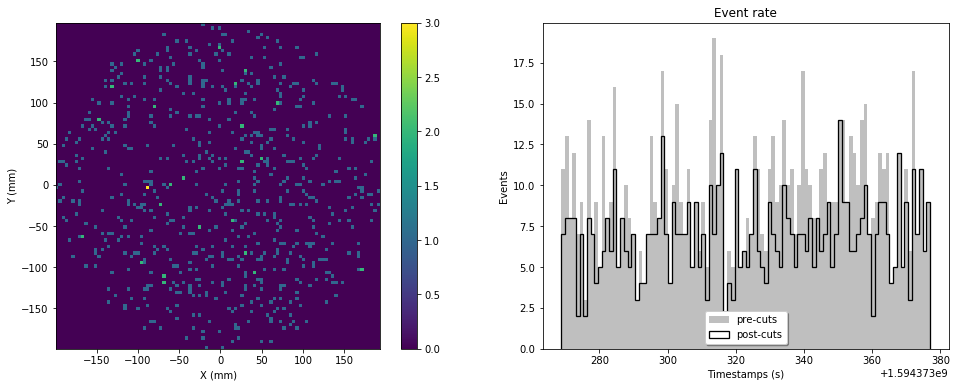

In [17]:
plt.figure(figsize=(16, 6));
plt.subplot(121);
plt.hist2d(sel_dst.X, sel_dst.Y, 100);
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');
plt.colorbar();
if run_number>0:
    plt.subplot(122);
    plt.hist(dst.time, 100, alpha=0.5, color='grey', label='pre-cuts')
    plt.hist(sel_dst.time, 100, histtype='step', color='k', linewidth=1.3, label='post-cuts')
    plt.legend(shadow=True, loc='lower center');
    plt.xlabel('Timestamps (s)');
    plt.ylabel('Events');
    plt.title('Event rate');

## Make Map

In [70]:
print(sel_dst.event.nunique(), 'events')
number_of_bins = 50
print('Number of XY bins: ', number_of_bins)

197 events
Number of XY bins:  50


In [67]:
map_params = {'nbins_z': 30,
              'nbins_e': 25,
              'z_range': (20, 550),
              'q_range': (400, 1000),
              'chi2_range': (0, 10),
              'lt_range': (200, 2000),
              'nmin': 100,
              'maxFailed': 10000,
              'r_max': 500,
              'r_fid': 100,
              'nStimeprofile': 1800,
              'x_range': (-200, 200),
              'y_range': (-200, 200)}

In [68]:
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

In [71]:
maps = calculate_map(dst        = sel_dst                 ,
                     XYbins     = (number_of_bins         ,
                                   number_of_bins)        ,
                     nbins_z    = map_params['nbins_z']   ,
                     nbins_e    = map_params['nbins_e']   ,
                     z_range    = map_params['z_range']   ,
                     e_range    = map_params['q_range']   ,
                     chi2_range = map_params['chi2_range'],
                     lt_range   = map_params['lt_range']  ,
                     fit_type   = FitType.unbined         ,
                     nmin       = map_params['nmin']      ,
                     x_range    = map_params['x_range']   ,
                     y_range    = map_params['y_range']   )

In [72]:
maps

ASectorMap(chi2=    0   1   2   3   4   5   6   7   8   9   ...  40  41  42  43  44  45  46  \
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
1  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
7  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
8  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
9  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
10 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
11 NaN NaN NaN NaN NaN NaN NaN NaN N

In [73]:
maxFailed = map_params['maxFailed']
r_max     = map_params['r_max']

check_failed_fits(maps      = maps          ,
                  maxFailed = maxFailed     ,
                  nbins     = number_of_bins,
                  rmax      = r_max         ,
                  rfid      = r_max         )

    Number of failing fits: 2032


In [42]:
regularized_maps = regularize_map(maps    = maps                    ,
                                  x2range = map_params['chi2_range'])

regularized_maps = relative_errors(am = regularized_maps)

In [ ]:
ax = fig.add_subplot(2,2,2)
ax.invert_yaxis()

In [61]:
from invisible_cities.reco.corrections        import read_maps
from invisible_cities.reco.corrections import apply_all_correction_single_maps
from krcal.NB_utils.plt_functions             import h1, h2
from krcal.NB_utils.fit_energy_functions      import fit_energy
from krcal.NB_utils.plt_energy_functions      import plot_fit_energy, print_fit_energy
from krcal.NB_utils.plt_energy_functions      import resolution_r_z, plot_resolution_r_z
from invisible_cities.reco.corrections        import apply_all_correction

In [47]:
# Checking map
sipm_map_file = "/Users/taylorcontreras/Development/Research/nz_analysis/data/trigger1/8087/maps/map_8087_test.h5"
pmt_map_file = "/Users/taylorcontreras/Development/Research/nz_analysis/data/trigger1/8087/maps/map_pmt_8087_test.h5"
sipm_map = read_maps(sipm_map_file)
pmt_map = read_maps(pmt_map_file)


In [55]:
geom_corr = e0_xy_correction(sipm_map)
correction = apply_all_correction_single_maps(sipm_map,pmt_map,apply_temp = False)

In [58]:
sel_dst = sel_dst[sel_dst.R<100]
corr_geo = geom_corr(sel_dst.X, sel_dst.Y)
corr_tot = correction(sel_dst.X, sel_dst.Y, sel_dst.Z, sel_dst.time)

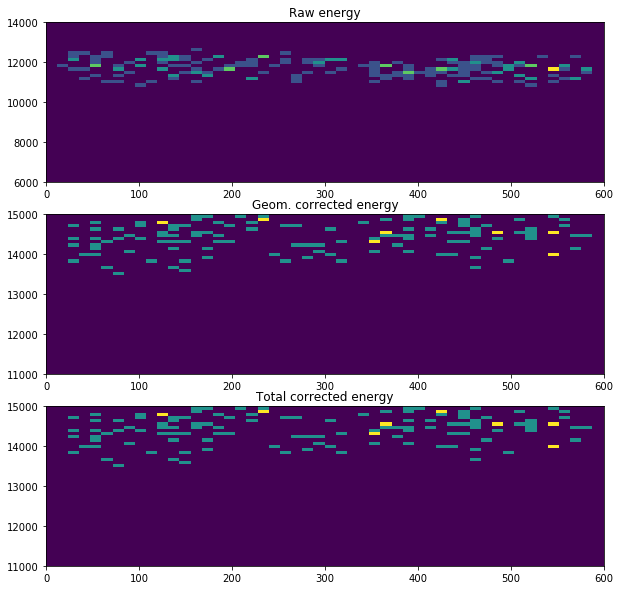

In [59]:
fig = plt.figure(figsize=(10,10))
plt.subplot(3, 1, 1)
plt.hist2d(sel_dst.Z, sel_dst.S2e, 50, [(0,600),(6000,14000)])
plt.title('Raw energy');
plt.subplot(3, 1, 2)
plt.hist2d(sel_dst.Z, sel_dst.S2e*corr_dst, 50, [(0,600),(11000,15000)])
plt.title('Geom. corrected energy');
plt.subplot(3, 1, 3)
plt.hist2d(sel_dst.Z, sel_dst.S2e*corr_tot, 50, [(0,600),(11000,15000)])
plt.title('Total corrected energy');

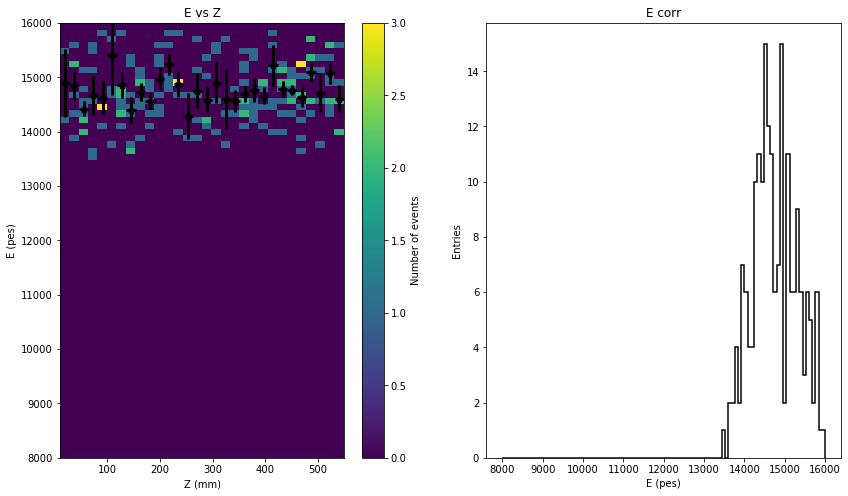

In [62]:
e_range = (8000,16000)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)

nevt = h2(sel_dst.Z, sel_dst.S2e*corr_tot, 30, 70, zrange, e_range, profile=True)
plt.xlabel('Z (mm)');
plt.ylabel('E (pes)');
plt.title('E vs Z');

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(sel_dst.S2e*corr_tot,  bins = 100, range =e_range, stats=True, lbl = 'E')
plt.xlabel('E (pes)');
plt.ylabel('Entries');
plt.title('E corr');

  Fit was valid = True
 Emu       = 14591.925132416 +-198.34815208569816 
 E sigma   = 621.7129903421257 +-192.35889171381015 
 chi2    = 1.0251003717824474 
 sigma E/E (FWHM)     (%) =10.012561838453541
 sigma E/E (FWHM) Qbb (%) =1.29314194945231 


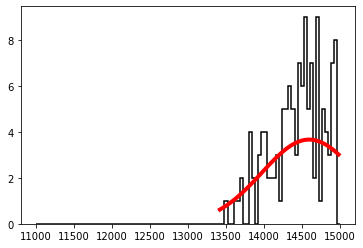

In [63]:
fc = fit_energy(sel_dst.S2e*corr_tot, nbins=100, range=(11000, 15000))
plot_fit_energy(fc)
print_fit_energy(fc)

In [19]:
## Testing lifetime
from krcal.core.fit_lt_functions import fit_lifetime, fit_lifetime_profile, lt_params_from_fcs
from krcal.NB_utils.plt_functions import plot_fit_lifetime

Text(0, 0.5, 'Q (SiPMs)')

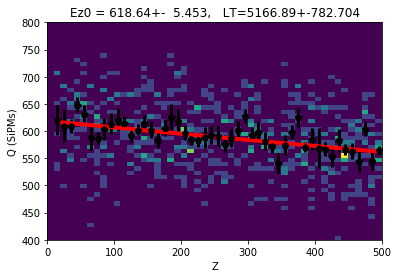

In [21]:
fc = fit_lifetime(sel_dst.Z, sel_dst.S2q, 50, 50, (0,500), (400,800))
plot_fit_lifetime(fc)
plt.ylabel('Q (SiPMs)')

Text(0, 0.5, 'E (PMTs)')

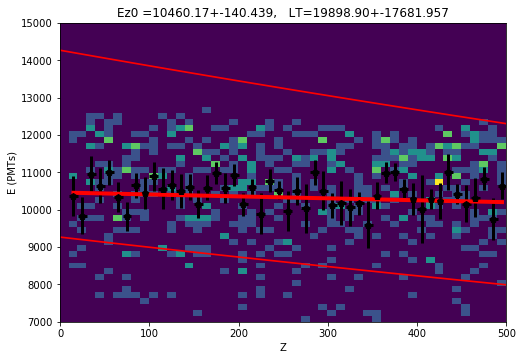

In [35]:
x, y, _ = profileX(dst[mask_s2].Z, dst[mask_s2].S2e, yrange=e_range_plot)
e0_seed, lt_seed = expo_seed(x, y)
lower_e0, upper_e0 = e0_seed-1000, e0_seed+4000    # play with these values to make the band broader or narrower

plt.figure(figsize=(8, 5.5))
xx = np.linspace(z_range_plot[0], z_range_plot[1], 100)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e, 50, [z_range_plot, e_range_plot], cmin=1);
plt.plot(xx, (lower_e0)*np.exp(xx/lt_seed), color='red', linewidth=1.7)
plt.plot(xx, (upper_e0)*np.exp(xx/lt_seed), color='red', linewidth=1.7)
plt.xlabel(r'Z ($\mu$s)');
plt.ylabel('S2e (pes)');

sel_krband = np.zeros_like(mask_s2)
Zs = dst[mask_s2].Z
sel_krband[mask_s2] = in_range(dst[mask_s2].S2e, (lower_e0)*np.exp(Zs/lt_seed), (upper_e0)*np.exp(Zs/lt_seed))

fc = fit_lifetime(sel_dst.Z, sel_dst.S2e, 50, 50, (0,500), (7000,15000))
plot_fit_lifetime(fc)
plt.ylabel('E (PMTs)')

In [36]:
lt_seed

-3374.6111384718088